# Aplicação básica do `sattsim`

**Higo Thaian Pereira da Silva** [(higo.thaian@gmail.com)](mailto:higo.thaian@gmail.com)

Neste _notebook_ são apresentadas as principais características do módulo `sattsim.py`, aplicado para simulações de interferência com redes de satélites. A principal referência deste módulo é a recomendação ITU-S 1503. Nas células a seguir, são explicitadas suas principais funcionalidades.

## Carregamento das bibliotecas

In [111]:
%load_ext autoreload
%autoreload 2
import sattsim as ss
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A classe da esfera terrestre - `Earth`

Para que a evolução temporal e modelo com múltiplos satélites funcione adequadamente, é necessário se definir uma esfera terrestre de referência. Para isso considere a Fig. 1, em que $R_{\mathrm{E}}$ é o raio da esfera terrestre e os vetores $\mathbf{x}$, $\mathbf{y}$ e $\mathbf{z}$ conformam uma base vetorial de referência denotada como $E = (\mathbf{x}, \mathbf{y}, \mathbf{z})$. Os vetores $\mathbf{x}$ e $\mathbf{y}$ estão contidos no plano do equador, enquanto o vetor $\mathbf{z}$, perpendicular a este plano, aponta para o polo norte e define o eixo central da rotação terrestre. Com esta geometria, um ponto qualquer na esfera terreste pode ser representado em coordenadas esféricas por
$$
  \begin{align}
    \mathbf{r} = \begin{bmatrix}
       x \\
       y \\
       z
     \end{bmatrix} = 
     R_{\mathrm{E}} \begin{bmatrix}
        \sin(\phi_{\mathrm{el}})\cos(\theta_{\mathrm{az}}) \\
        \sin(\phi_{\mathrm{el}})\sin(\theta_{\mathrm{az}}) \\
        \sin(\phi_{\mathrm{el}})
     \end{bmatrix},
  \end{align}
  \\
  \\
$$
em que $\theta_{\mathrm{az}}$ é o ângulo azimutal e $\phi_{\mathrm{el}}$ é o ângulo em elevaçao, ambos referentes à base $E$. A posição $\mathbf{r}$ pode também ser representado pelos ângulos de longitude e latitude $\theta_{\mathrm{long}}$ e $\phi_{\mathrm{lat}}$, respectivamente. A relação entre os ângulos ($\theta_{\mathrm{az}}$,$\phi_{\mathrm{el}}$) e ($\theta_{\mathrm{long}}$, $\phi_{\mathrm{lat}}$) se dá por
$$
\theta_{\mathrm{az}} = \theta_{\mathrm{long}},
$$
e
$$
\phi_{\mathrm{el}} = -\phi_{\mathrm{lat}} + \frac{\pi}{2}.
$$



<figure>
<img src="./docs/figs/earth_geom.png" style="width:100%">
<figcaption align = "center"> Fig. 1: Geometria de referência da esfera terrestre. </figcaption>
</figure>

Para que uma posição permaneça fixa na medida que a esfera terrestre rotaciona, é necessário rotacionar a base vetorial $E$ em torno do eixo definido por $\mathbf{z}$. A matriz de rotação sob esse eixo é definida como
$$
  \begin{align}
    \mathbf{R}_{z}(t) = 
     \begin{bmatrix}
        \cos(\Omega_{\mathrm{e}} t) & -\sin(\Omega_{\mathrm{e}} t) & 0 \\
        \sin(\Omega_{\mathrm{e}} t) & \cos(\Omega_{\mathrm{e}} t) & 0 \\
        0 & 0 & 1
     \end{bmatrix},
  \end{align}
$$
em que $\Omega_{\mathrm{e}}$ é a taxa angular de rotação terrestre e $t$ é um instante de tempo. Com isso, a base vetorial em um instante $t$ qualquer é determinada por
$$
E(t) = ( \mathbf{x}(t), \mathbf{y}(t), \mathbf{z} ) = \left( \mathbf{R}_{z}(t)\mathbf{x}, \mathbf{R}_{z}(t)\mathbf{y}, \mathbf{z} \right).
$$




### Exemplos com a classe `Earth`

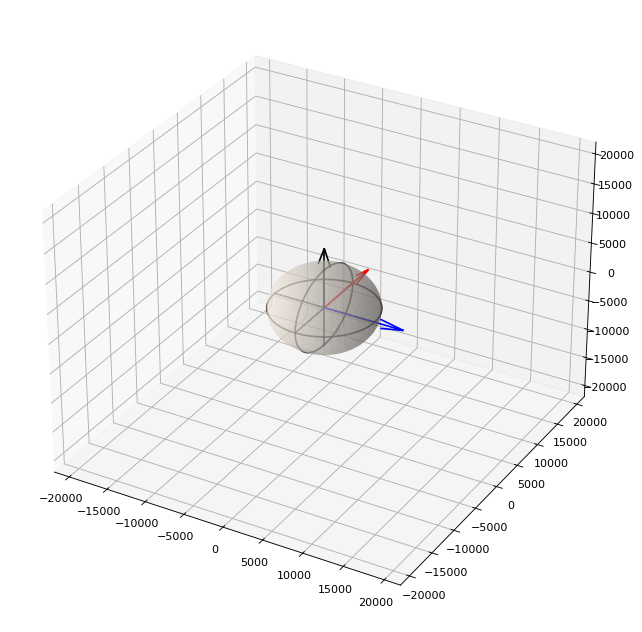

In [15]:
# Criar um instância de terra
earth = ss.Earth()
# Plotar terra
earth.plot_earth()

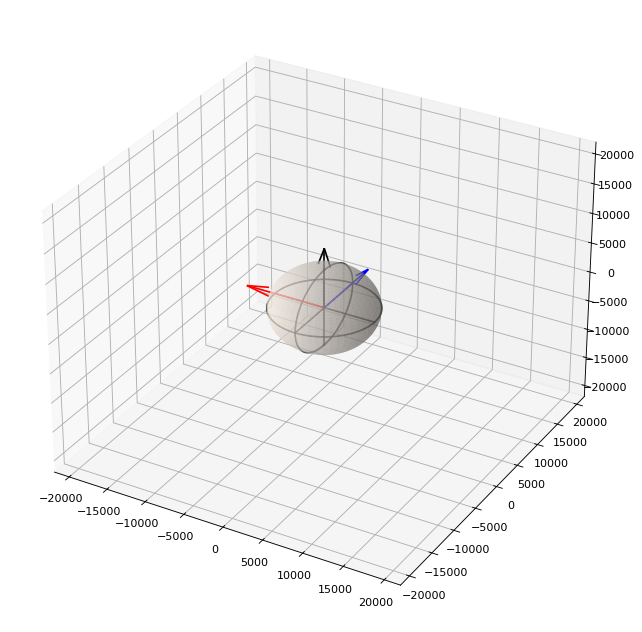

In [16]:
# Rotacionar por 1/4 de dia
earth.update_position( 21600 )
# Plotar
earth.plot_earth()

## A classe de antenas - `SatAntenna`


O padrão de radiação das antenas é modelado de acordo com a expressão
$$ G_{\mathrm{s}}( \mathbf{r}_{\mathrm{b}}, \mathbf{r} ) = G_{0} ( \mathbf{r}_{\mathrm{b}} \cdot \mathbf{r} )^{\left(\frac{G_{0}}{2} - 1\right)} = G_{0} [ \cos(\theta_{\mathrm{d}}) ]^{\left(\frac{G_{0}}{2} - 1\right)}, $$
em que $\mathbf{r}_{\mathrm{b}}$ é o vetor direção de apontamento do feixe, $\mathbf{r}$ é um vetor direção arbitrário, $\theta_{\mathrm{d}}$ é o ângulo entre os vetores $\mathbf{r}_{\mathrm{b}}$ e $\mathbf{r}$, e $G_{0}$ é ganho máximo na direção $\mathbf{r}_{\mathrm{b}}$. De acordo com esta expressão, o ganho máximo $G_{0}$ se relaciona com o HPBW ($\theta_{\text{3dB}}$) da antena por
$$ G_{0} = 2\left( 1 - \frac{1}{\log_{2}[ \cos( \theta_{\text{3dB}} ) ]} \right).$$

Além disso, a base vetorial de uma antena é definida como $A = (\bar{\mathbf{a}}, \bar{\mathbf{b}}, \bar{\mathbf{r}}_{\mathrm{b}})$ em que $\bar{\mathbf{r}}_{\mathrm{b}}$ é o vetor direção do feixe normalizado ($||\bar{\mathbf{r}}_{\mathrm{b}}|| = 1$). A partir desta base, pode-se definir o cone que representa o feixe de forma simples. A intersecção do cone com a esfera terrestre pode ser resolvida por um teste de intercepção raio-esfera de baixo custo computacional.


Seguindo este modelo, uma instância de antena de satelite é criada por meio da classe `SatAntenna`, que recebe como entradas:
1. `beam_dir_vector: List[float]`: lista de três elementos `float` representando a direção central do feixe da antena ($\mathbf{r}_{\mathrm{b}}$). O vetor de entrada não precisa ser normalizado, este procedimento é feito internamente à instanciação.
1. `hpbw_dg: float`: HPBW da antena expresso em graus (°).

A classe `SatAntenna` tem como métodos:
1. `ant_gain_on_direction( dir_vector: List[float] )`: Este método calcula o ganho da antena em um direção arbitrária indicada pelo vetor de entrada `dir_vector: List[float]`. O vetor de entrada não precisa ser normalizado, este procedimento é feito internamente à função.
1. `ant_gain_on_angle( dir_angle: float )`: Este método calcula o ganho da antena baseado no ângulo $\theta_{\mathrm{d}}$, indicado pela entrada `dir_angle`, que deve ser expresso em graus (°).


### Exemplo com a classe `SatAntenna`

SatAntenna((0.000,0.196,0.981), 10°)
SatAntenna((0.000,0.196,0.981), 5°)
SatAntenna((0.000,0.196,0.981), 3°)
SatAntenna((0.000,0.196,0.981), 1.5°)


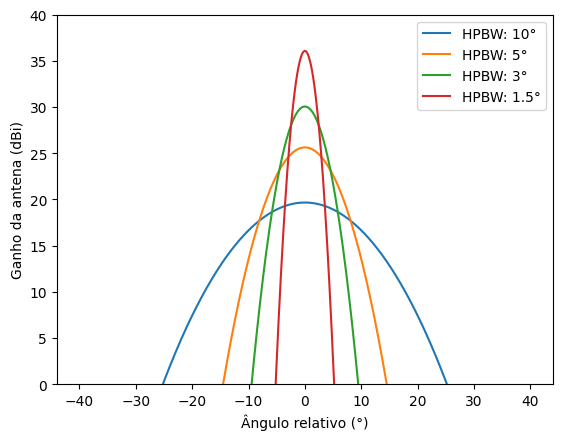

In [4]:
# Determinação de múltiplas HPBWs (°)
hpbw_dg_l = [ 10, 5, 3, 1.5 ]
# Vetor de direção do feixe (direção arbitrária)
beam_dir_vector = [0,1.0,5.0]

for hpbw in hpbw_dg_l:
    
    # Criação de uma instância de antena
    sat_ant = ss.SatAntenna( beam_dir_vector, hpbw )
    # Representação da instância
    print(repr(sat_ant))

    # Eixo de ângulos
    th_dg_ax = np.linspace( -4 * hpbw, 4 * hpbw, 1000 )
    gain_dbi_r = []
    for th_dg in th_dg_ax:
        
        gain_dbi = 10 * np.log10( sat_ant.ant_gain_on_angle( th_dg ) )
        gain_dbi_r.append( gain_dbi )

    plt.plot(th_dg_ax, gain_dbi_r, label=f'HPBW: {hpbw}°')

plt.legend()
plt.ylim([0,40])
plt.xlabel('Ângulo relativo (°)')
plt.ylabel('Ganho da antena (dBi)')
plt.show()

## A classe de satélite geoestacionário - `GeoSatellite`


Um **satélite geoestacionário** possui **orbita circular simples** e sincrona com a rotação terrestre, a uma taxa de $4.178074\times 10^{-3}$ graus/s e raio de 42164.2 km (referente ao ponto central da esfera terrestre). Além disso, esta orbita é **contida no plano do corta o eixo do equador**. Sabendo disso, a orbita de um satelite geoestacionário pode ser **completamente caracterizada em por uma longitude inicial**, referente ao **meridiano de Greenwich**. A geometria da orbita de um satélite geoestacionário é ilustrada na figura abaixo, em que $R_{\mathrm{G}}$ é o **raio da orbita** e $\vartheta_{\mathrm{G}}$ é a **longitude no instante inicial**.

<figure>
<img src="./docs/figs/geo_geom.png" style="width:100%">
<figcaption align = "center"> Fig. 2: Geometria do movimento de um satelite geoestacionário. </figcaption>
</figure>


A evolução temporal da posição de um satelite geoestacionário é descrita por
$$
  \begin{align}
    \mathbf{r}_{\mathrm{G}}(t) = \begin{bmatrix}
       x(t) \\
       y(t) \\
       z(t)
     \end{bmatrix} = 
     \begin{bmatrix}
       R_{\mathrm{G}} \sin(\phi_{\mathrm{G}})\cos(\vartheta_{\mathrm{G}} + \Omega_{\mathrm{e}} t) \\
       R_{\mathrm{G}} \sin(\phi_{\mathrm{G}})\sin(\vartheta_{\mathrm{G}} + \Omega_{\mathrm{e}} t) \\
       R_{\mathrm{G}} \cos(\phi_{\mathrm{G}})
     \end{bmatrix},
  \end{align}
$$
em que $\phi_{\mathrm{G}} = \pi/2$ é o ângulo de elevação no plano do equador e $\Omega_{\mathrm{e}}$ é a velocidade angular de rotação da terra. Logo, o vetor velocidade correspondente ao trajeto é descrito por
$$
  \begin{align}
    \mathbf{v}_{\mathrm{G}}(t) = \frac{d}{dt}\mathbf{r}_{\mathrm{G}}(t) = 
     \begin{bmatrix}
       -\Omega_{\mathrm{e}} R_{\mathrm{G}} \sin(\phi_{\mathrm{G}})\sin(\vartheta_{\mathrm{G}} + \Omega_{\mathrm{e}} t) \\
       \Omega_{\mathrm{e}} R_{\mathrm{G}} \sin(\phi_{\mathrm{G}})\cos(\vartheta_{\mathrm{G}} + \Omega_{\mathrm{e}} t) \\
       0
     \end{bmatrix} =
    \Omega_{\mathrm{e}}\begin{bmatrix}
       -y(t) \\
       x(t) \\
       0
     \end{bmatrix}.
  \end{align}
$$
Denotando $\bar{\mathbf{r}}_{\mathrm{G}}(t)$ e $\bar{\mathbf{v}}_{\mathrm{G}}(t)$ como os vetores posição e velocidade normalizados, isto é, $||\bar{\mathbf{r}}_{\mathrm{G}}(t)|| = ||\bar{\mathbf{v}}_{\mathrm{G}}(t)|| = 1$, a **base vetorial de referência do satélite** é definida como $G = ( \bar{\mathbf{v}}_{\mathrm{G}}(t), \bar{\mathbf{r}}_{\mathrm{G}}(t), \bar{\mathbf{t}}_{\mathrm{G}}(t) )$, em que $\bar{\mathbf{t}}_{\mathrm{G}}(t) = \bar{\mathbf{r}}_{\mathrm{G}}(t) \times \bar{\mathbf{v}}_{\mathrm{G}}(t)$. A Figura abaixo apresenta a geometria das bases vetoriais da terra e do satélite.

<figure>
<img src="./docs/figs/geosat_fixed_geom.png" style="width:100%">
<figcaption align = "center"> Fig. 2: Geometria de bases vetoriais. </figcaption>
</figure>

A classe `GeoSatellite` é usada para modelar um satélite geoestacionário. Uma instância desta classe é criada com as seguintes entradas:
1. `init_az (float)`: Ângulo azimutal inicial ($\vartheta_{\mathrm{G}}$) referenciado na base $E$;
1. `lat_long_target_position (List[float])`: Lista com coordenadas em latitude e longitude de um ponto de referência na superfície terrestre no qual o feixe do satelite está direcionado.
1. `ant_hpbw (float)`: HPBW (expressa em graus) da antena do satélite.

A classe `GeoSatellite` conta com os seguintes métodos públicos:
1. `update_position( t: float )`: Atualiza os atributos da instância para o instante $t$ (tempo absoluto) no tempo.
1. `plot_sat()`: Plota a posição do satelite, a base vetorial, o vetor do feixe e a esfera terrestre.
1. `plot_sat_path()`: Plota a posição relativa do satelite em um mapa.

### Exemplo com a classe `GeoSatellite`

In [86]:
# HPBW da antena do satélite
sat_hpbw = 1.5
# Posição na superfície terrestre a qual o satelite está direcionando o feixe no instante inicial
target_pos = [0, 0]
# Azimute inicial do satélite geoestacionário
az_init = 0.0

# Criar instância de satélite Geo
geo_sat = ss.GeoSatellite( az_init, target_pos, sat_hpbw )

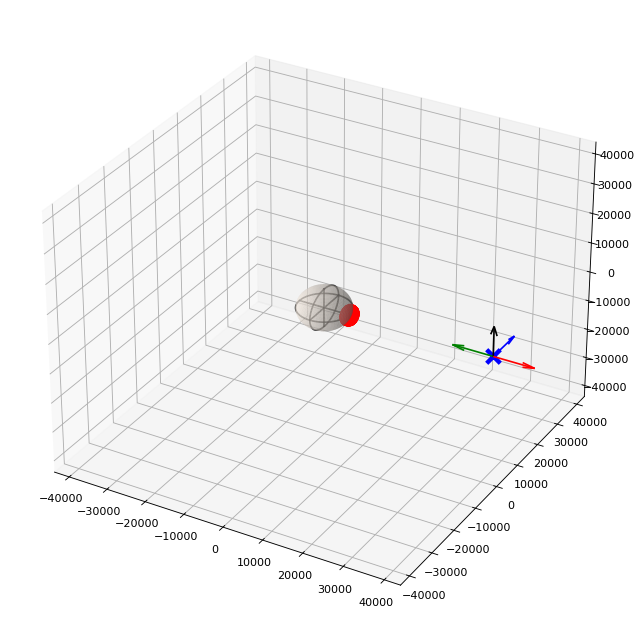

In [87]:
# Plotar satelite
geo_sat.plot_sat()

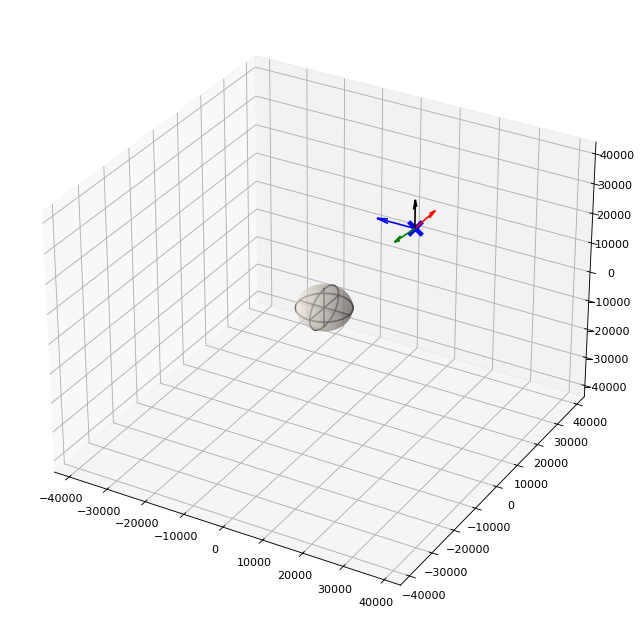

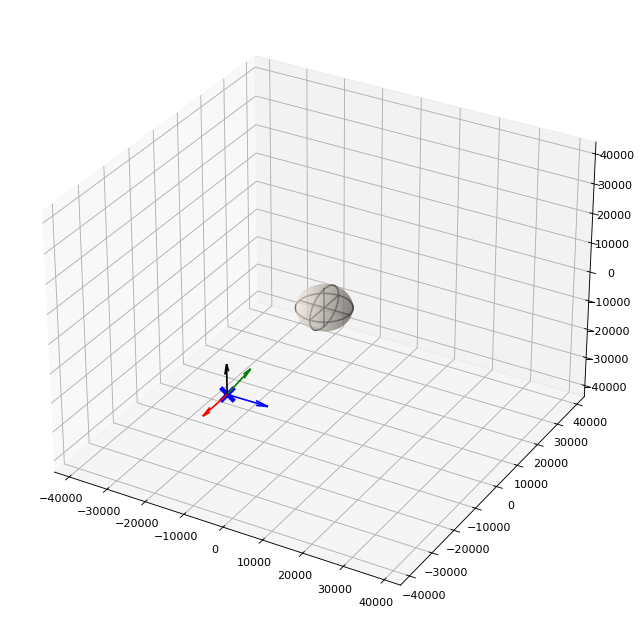

In [10]:
t = 0
dt = 21600
# Atualizar posição em um quarto de dia (21600 s)
t = t + dt
geo_sat.update_position(t)
geo_sat.plot_sat()

# Atualizar posição em um quarto de dia (21600 s)
t = t + dt
geo_sat.update_position(t)
geo_sat.plot_sat()

In [11]:
# Criar instância de satélite Geo
geo_sat = ss.GeoSatellite( az_init, target_pos, sat_hpbw )

# Variar posição em 200 frames, com passo de 432 s
for i in range(200):
    geo_sat.update_position(432)

### Gerar .gif com movimento do satélite

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import io

def create_plot(i):
    geo_sat.update_position(i)
    fig = geo_sat.plot_sat( return_fig = True )
    
frames = []
for i in range(200):
    create_plot(432)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frames.append(Image.open(buf))
    
frames[0].save('./docs/figs/geosat_motion.gif', 
               save_all=True, 
               append_images=frames[1:], 
               loop=0)

# A classe de sistema `System`

In [115]:
# Nível de abertura do cone
cone_aperture = 20.0

# GEO-SAT 1 -----------------------------------------------------------------------------------------
# HPBW da antena do satélite
sat_hpbw = 1.5
# Posição na superfície terrestre a qual o satelite está direcionando o feixe no instante inicial
target_pos = [0, 0]
# Azimute inicial do satélite geoestacionário
az_init = 0.0
# Criar instância de satélite Geo
geo_sat = ss.GeoSatellite( 'Geo 1', az_init, target_pos, sat_hpbw )

# GEO-SAT 2 -----------------------------------------------------------------------------------------
# HPBW da antena do satélite
sat_hpbw = 1.5
# Posição na superfície terrestre a qual o satelite está direcionando o feixe no instante inicial
target_pos = [0, np.deg2rad( 30 )]
# Azimute inicial do satélite geoestacionário
az_init = np.deg2rad( 30 )
# Criar instância de satélite Geo
geo_sat2 = ss.GeoSatellite( 'Geo 2', az_init, target_pos, 4 )

# Criar um instância de terra
earth = ss.Earth()

# Instância de sistema
sys = ss.System( earth, [], [geo_sat, geo_sat2], [], cone_aperture = cone_aperture )

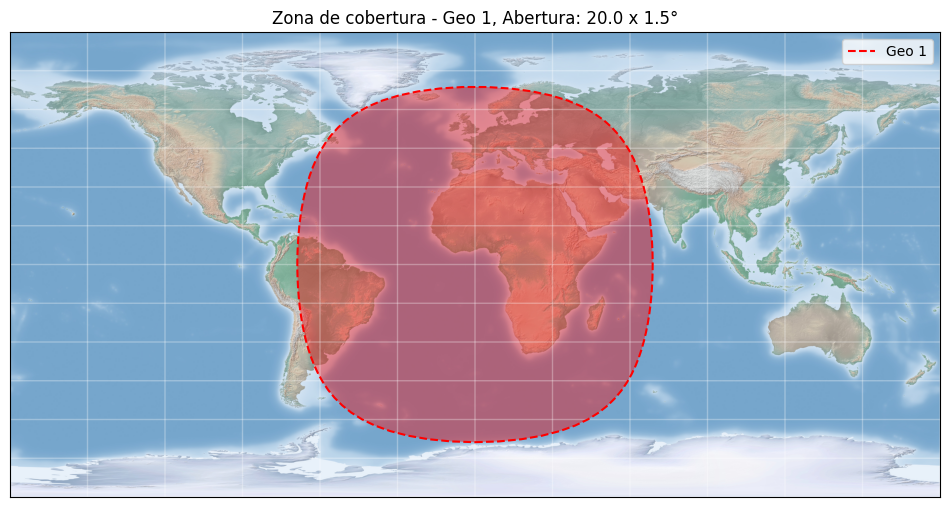

In [116]:
sys.plot_current_coverage_zone('Geo 1')

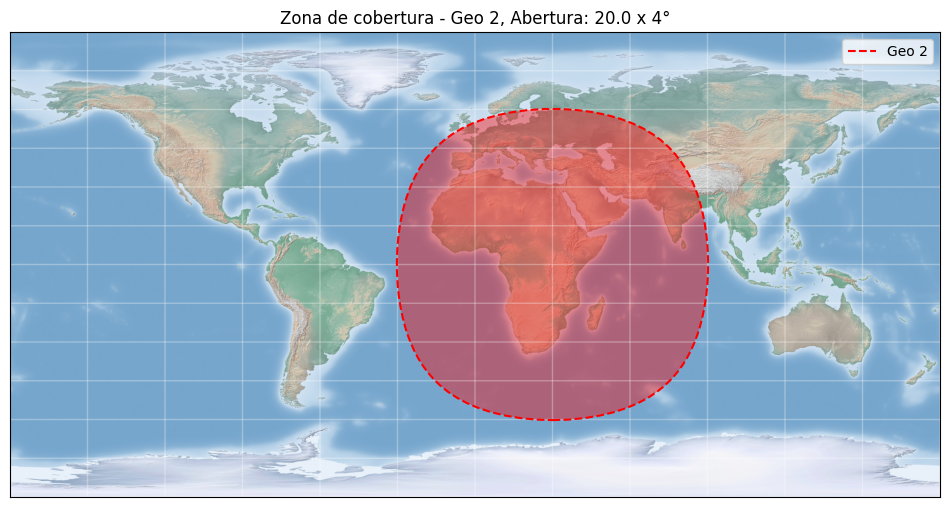

In [117]:
sys.plot_current_coverage_zone('Geo 2')